In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

In [3]:
df = pd.read_csv("./DataExpo2018/forecasts_vs_observed.csv", parse_dates=['target_date','forecast_issue_date'])
df

,target_date,city,state,airptcd,forecast_issue_date,forecast_var,forecast_prob,precip_in,rain_outcome
0,2014-07-09,Eastport,Maine,KBHB,2014-07-09,ProbPrecip,0.0,0.00,0
1,2014-07-09,Eastport,Maine,KBHB,2014-07-09,ProbPrecip,0.0,0.00,0
2,2014-07-10,Eastport,Maine,KBHB,2014-07-09,ProbPrecip,0.0,0.03,1
3,2014-07-10,Eastport,Maine,KBHB,2014-07-09,ProbPrecip,0.0,0.03,1
4,2014-07-11,Eastport,Maine,KBHB,2014-07-09,ProbPrecip,0.0,0.00,0
...,...,...,...,...,...,...,...,...,...
1600659,2017-09-05,Honolulu,Hawaii,PHNL,2017-09-01,ProbPrecip,0.2,NaN,0
1600660,2017-09-05,Honolulu,Hawaii,PHNL,2017-09-01,ProbPrecip,0.2,NaN,0
1600661,2017-09-06,Honolulu,Hawaii,PHNL,2017-09-01,ProbPrecip,0.4,NaN,0
1600662,2017-09-06,Honolulu,Hawaii,PHNL,2017-09-01,ProbPrecip,0.5,NaN,0


In [5]:
def brier_score(p, y):
    """Mean squared error for probabilistic forecasts"""
    return np.mean((p - y)**2)

def log_score(p, y, eps=1e-15):
    """Negative log likelihood"""
    p = np.clip(p, eps, 1 - eps)
    return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

def expected_calibration_error(df, n_bins=10):
    """ECE: bins predicted probabilities and measures deviation from observed fraction"""
    bins = np.linspace(0, 1, n_bins + 1)
    binids = np.digitize(df['forecast_prob'], bins) - 1
    ece = 0.0
    for i in range(n_bins):
        idx = binids == i
        if np.sum(idx) > 0:
            p_hat = df.loc[idx, 'forecast_prob'].mean()
            y_hat = df.loc[idx, 'rain_outcome'].mean()
            ece += np.sum(idx) * abs(p_hat - y_hat)
    ece /= len(df)
    return ece

In [17]:
# scores
forecasters = df['airptcd'].unique()
results = []

for f in forecasters:
    df_f = df[df['airptcd'] == f]
    if len(df_f) < 10:  # skip stations with too few forecasts
        continue
    bs = brier_score(df_f['forecast_prob'], df_f['rain_outcome'])
    ls = log_score(df_f['forecast_prob'], df_f['rain_outcome'])
    ece = expected_calibration_error(df_f, n_bins=10)
    results.append({
        'forecaster': f,
        'brier_score': bs,
        'log_score': ls,
        'ece': ece,
        'n_forecasts': len(df_f)
    })

scores_df = pd.DataFrame(results)
scores_df = scores_df.sort_values('brier_score')  # lower is better
print("Forecaster rankings by Brier Score:")
scores_df[['forecaster','brier_score','log_score','ece','n_forecasts']]

Forecaster rankings by Brier Score:


,forecaster,brier_score,log_score,ece,n_forecasts
77,KBJC,0.026356,0.130615,0.059695,14440
94,KVGT,0.047047,1.216217,0.040245,14444
93,KEED,0.049291,1.312223,0.041142,14445
98,KSAN,0.053004,1.412930,0.046565,13551
101,KCQT,0.070771,2.020481,0.065702,14444
...,...,...,...,...,...
106,KBFI,0.266054,7.627954,0.254900,14430
40,KGRR,0.286543,7.782323,0.265339,13736
55,KDLH,0.295847,8.788481,0.292690,14446
110,KHQM,0.305657,9.108959,0.315437,14446


In [18]:
# calibration
def plot_calibration_subplot(ax, df, forecaster, n_bins=10):
    df_f = df[df['airptcd'] == forecaster]
    if len(df_f) == 0:
        return
    
    bins = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    binids = np.digitize(df_f['forecast_prob'], bins) - 1

    observed_frac = []
    for i in range(n_bins):
        idx = binids == i
        if np.sum(idx) > 0:
            observed_frac.append(df_f.loc[idx, 'rain_outcome'].mean())
        else:
            observed_frac.append(np.nan)

    ax.plot(bin_centers, observed_frac, marker='o')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_xlabel("Forecast Probability")
    ax.set_ylabel("Observed Frequency")
    ax.set_title(f"Calibration: {forecaster}")
    ax.set_ylim(0, 1)

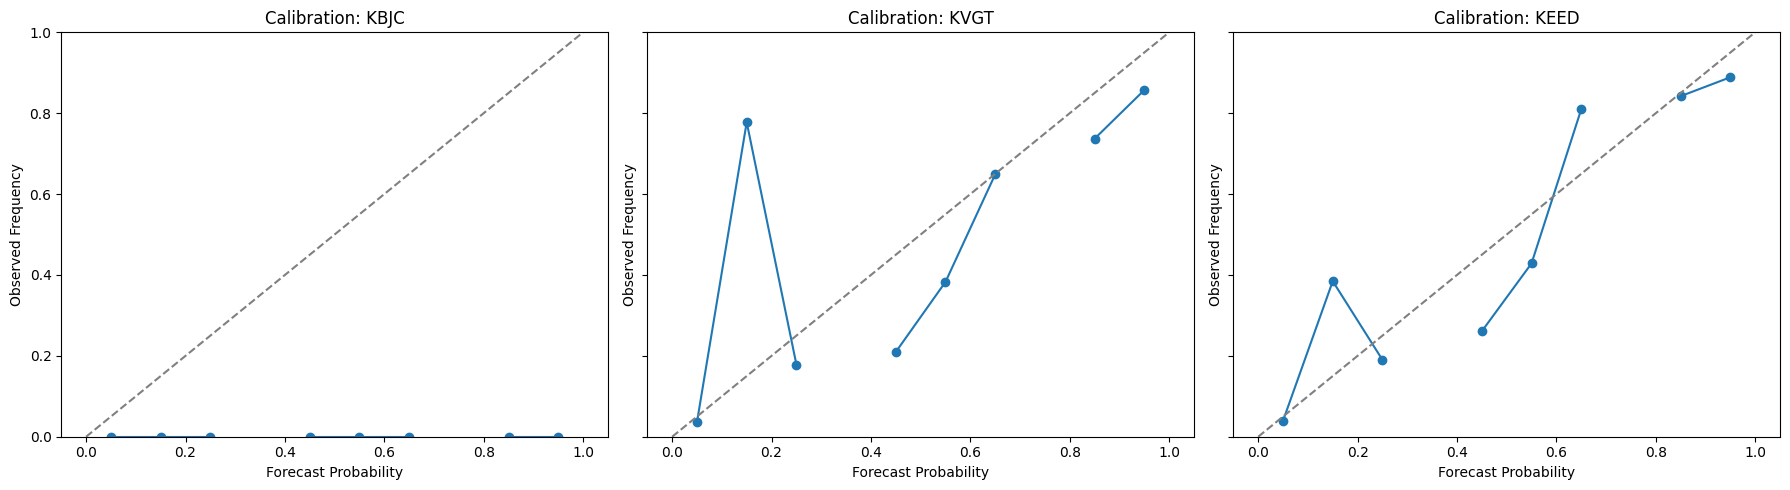

In [19]:
top3 = scores_df['forecaster'].head(3).tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, forecaster in zip(axes, top3):
    plot_calibration_subplot(ax, df, forecaster)

plt.tight_layout()
plt.show()

In [11]:
df[df['airptcd']=="KBJC"]['rain_outcome'].mean()

0.0

In [14]:
df[(df['airptcd']=="KBJC") & (df['forecast_prob'] > 0.5)]

,target_date,city,state,airptcd,forecast_issue_date,forecast_var,forecast_prob,precip_in,rain_outcome
5637,2014-07-12,Denver,Colorado,KBJC,2014-07-12,ProbPrecip,0.6,0.0,0
30079,2014-07-30,Denver,Colorado,KBJC,2014-07-28,ProbPrecip,0.6,0.0,0
31607,2014-07-30,Denver,Colorado,KBJC,2014-07-29,ProbPrecip,0.7,0.0,0
33135,2014-07-30,Denver,Colorado,KBJC,2014-07-30,ProbPrecip,0.8,0.0,0
33136,2014-07-30,Denver,Colorado,KBJC,2014-07-30,ProbPrecip,0.6,0.0,0
...,...,...,...,...,...,...,...,...,...
1561417,2017-08-06,Denver,Colorado,KBJC,2017-08-06,ProbPrecip,0.6,0.0,0
1561418,2017-08-07,Denver,Colorado,KBJC,2017-08-06,ProbPrecip,0.7,0.0,0
1561419,2017-08-07,Denver,Colorado,KBJC,2017-08-06,ProbPrecip,0.6,0.0,0
1562978,2017-08-07,Denver,Colorado,KBJC,2017-08-07,ProbPrecip,0.8,0.0,0


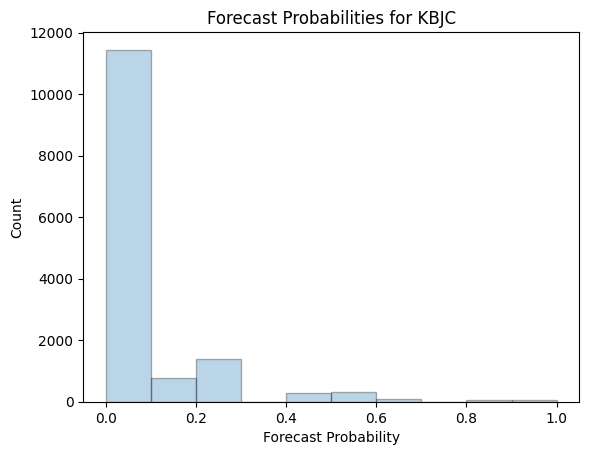

In [25]:
df_f = df[df['airptcd']=='KBJC']
plt.hist(df_f['forecast_prob'], bins=10, alpha=0.3, edgecolor='black')
plt.title("Forecast Probabilities for KBJC")
plt.xlabel("Forecast Probability")
plt.ylabel("Count")
plt.show()

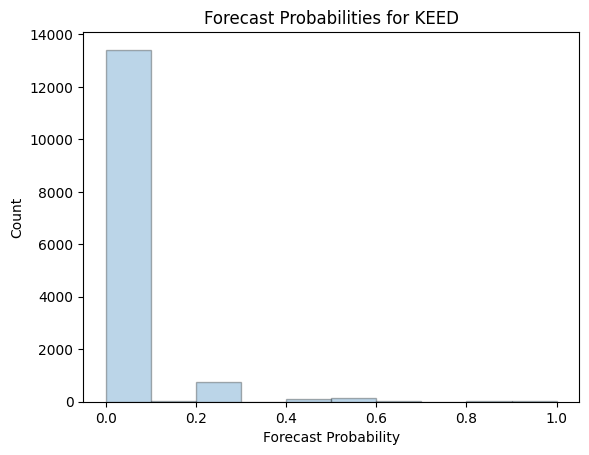

In [37]:
df_f = df[df['airptcd']=='KEED']
plt.hist(df_f['forecast_prob'], bins=10, alpha=0.3, edgecolor='black')
plt.title("Forecast Probabilities for KEED")
plt.xlabel("Forecast Probability")
plt.ylabel("Count")
plt.show()

In [21]:
def print_bin_counts(df, forecaster, n_bins=10):
    df_f = df[df['airptcd'] == forecaster]

    if len(df_f) == 0:
        print("No data for forecaster:", forecaster)
        return

    # Same bins as calibration plot
    bins = np.linspace(0, 1, n_bins + 1)
    binids = np.digitize(df_f['forecast_prob'], bins) - 1

    print(f"Bin counts for {forecaster}:")
    for i in range(n_bins):
        count = np.sum(binids == i)
        print(f"  Bin {i} ({bins[i]:.1f} – {bins[i+1]:.1f}): {count} predictions")

print_bin_counts(df, "KBJC")

Bin counts for KBJC:
  Bin 0 (0.0 – 0.1): 11445 predictions
  Bin 1 (0.1 – 0.2): 759 predictions
  Bin 2 (0.2 – 0.3): 1391 predictions
  Bin 3 (0.3 – 0.4): 0 predictions
  Bin 4 (0.4 – 0.5): 295 predictions
  Bin 5 (0.5 – 0.6): 320 predictions
  Bin 6 (0.6 – 0.7): 102 predictions
  Bin 7 (0.7 – 0.8): 0 predictions
  Bin 8 (0.8 – 0.9): 63 predictions
  Bin 9 (0.9 – 1.0): 45 predictions


Correlation Between Brier Score and Calibration (ECE)
Pearson r = 0.948  (p = 4.85e-57)
Spearman ρ = 0.957  (p = 3.01e-61)


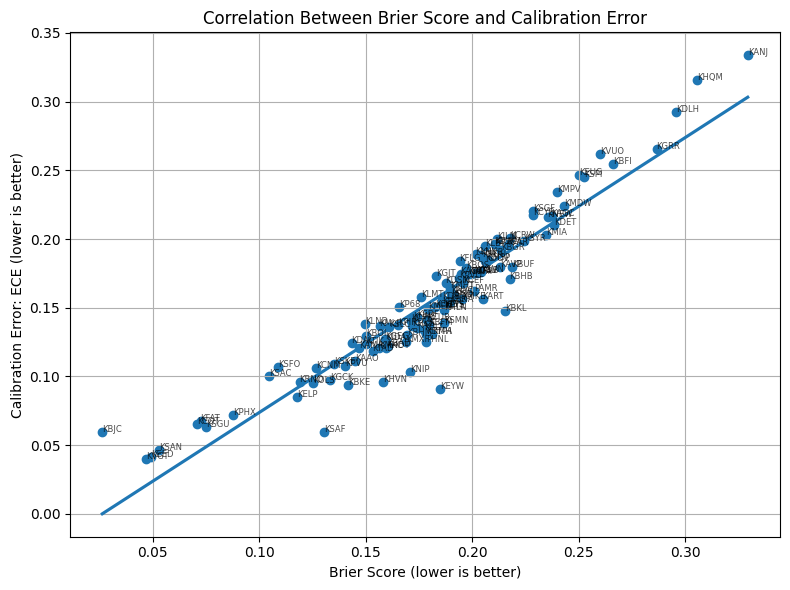

In [30]:
def plot_brier_vs_ece(scores_df):
    brier = scores_df["brier_score"]
    ece = scores_df["ece"]

    # --- Compute Correlations ---
    pear_corr, pear_p = pearsonr(brier, ece)
    spear_corr, spear_p = spearmanr(brier, ece)

    print("Correlation Between Brier Score and Calibration (ECE)")
    print(f"Pearson r = {pear_corr:.3f}  (p = {pear_p:.3g})")
    print(f"Spearman ρ = {spear_corr:.3f}  (p = {spear_p:.3g})")

    # --- Plot ---
    plt.figure(figsize=(8, 6))
    plt.scatter(brier, ece)

    # label points
    for _, row in scores_df.iterrows():
        plt.text(row["brier_score"], row["ece"], row["forecaster"], fontsize=6, alpha=0.7)

    # optional regression line
    sns.regplot(x=brier, y=ece, scatter=False, ci=None)

    plt.xlabel("Brier Score (lower is better)")
    plt.ylabel("Calibration Error: ECE (lower is better)")
    plt.title("Correlation Between Brier Score and Calibration Error")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_brier_vs_ece(scores_df)